In [19]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time


In [20]:
# Cell 2: Define CNN Model
device = torch.device("cpu")

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 → 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 → 7x7
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [21]:
# Cell 3: Load Data
transform = transforms.ToTensor()
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

# Add Gaussian Noise to test set
def add_noise(tensor, std=0.5):
    return torch.clip(tensor + torch.randn_like(tensor) * std, 0., 1.)

noisy_test_images = add_noise(test_data.data.unsqueeze(1).float() / 255.)
noisy_test_loader = DataLoader(TensorDataset(noisy_test_images, test_data.targets), batch_size=1000)


In [22]:
# Cell 4: Training and Evaluation with Timing
def train(model, loader, optimizer, criterion, epochs=3):
    start_time = time.time()
    model.train()
    for ep in range(epochs):
        total, correct = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total += y.size(0)
            correct += (out.argmax(1) == y).sum().item()
        print(f"Epoch {ep+1}: Accuracy = {correct/total:.4f}")
    elapsed = time.time() - start_time
    print(f"Training time: {elapsed:.2f} seconds")
    return elapsed

def evaluate(model, loader):
    model.eval()
    correct = 0
    start_time = time.time()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    elapsed = time.time() - start_time
    accuracy = correct / len(loader.dataset)
    return accuracy, elapsed


In [23]:
# Cell 5: Train Baseline Model
baseline = CNNModel().to(device)
optimizer = optim.Adam(baseline.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_time = train(baseline, train_loader, optimizer, criterion)


Epoch 1: Accuracy = 0.9420
Epoch 2: Accuracy = 0.9840
Epoch 3: Accuracy = 0.9895
Training time: 62.08 seconds


In [24]:
# Cell 6: Define Weight Sharing (Quantization)
def apply_weight_sharing(model, bits=4):
    """
    Apply weight sharing by quantizing weights uniformly.
    """
    n_clusters = 2 ** bits
    for name, param in model.named_parameters():
        if "weight" in name and len(param.shape) > 1:
            W = param.data
            W_min, W_max = W.min(), W.max()
            step = (W_max - W_min) / (n_clusters - 1)
            quantized = torch.round((W - W_min) / step) * step + W_min
            param.data = quantized
    return model


In [25]:
# Cell 7: Evaluate Baseline and Compressed Models with Timing
# Baseline evaluation
acc_clean, time_clean = evaluate(baseline, test_loader)
acc_noisy, time_noisy = evaluate(baseline, noisy_test_loader)

# Compressed model
model_compressed = CNNModel().to(device)
model_compressed.load_state_dict(baseline.state_dict())
model_compressed = apply_weight_sharing(model_compressed, bits=4)

acc_clean_c, time_clean_c = evaluate(model_compressed, test_loader)
acc_noisy_c, time_noisy_c = evaluate(model_compressed, noisy_test_loader)


        Model  Clean Accuracy (%)  Noisy Accuracy (%)  \
0    Baseline               98.95               72.82   
1  Compressed               98.82               70.64   

   Clean Inference Time (s)  Noisy Inference Time (s) Training Time (s)  
0                  1.011741                  0.920152         62.077672  
1                  0.924205                  0.724259                 -  


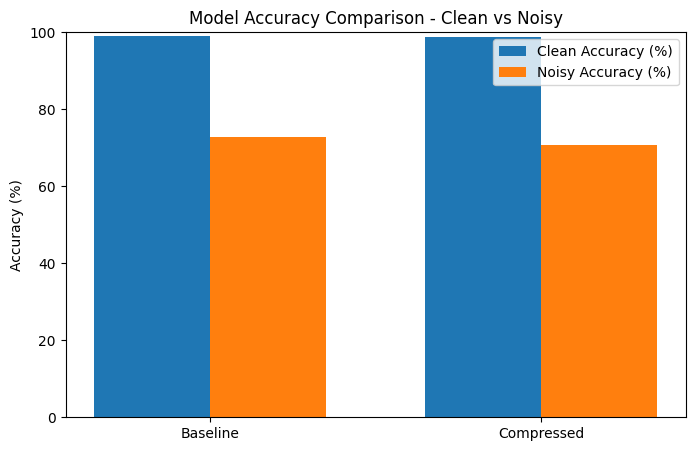

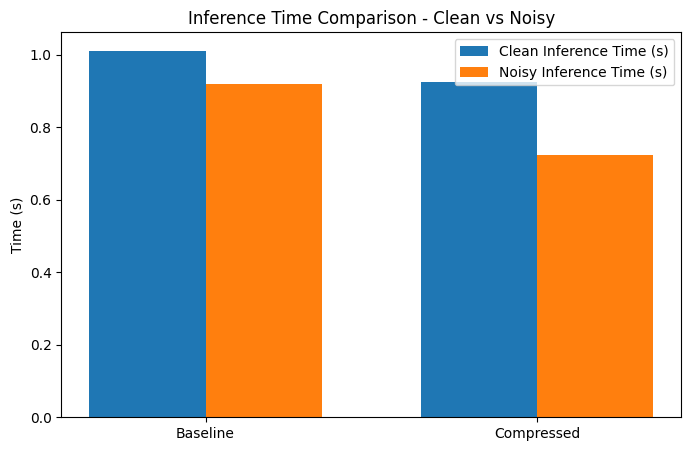

In [26]:
# === Final Comparison Table ===
df = pd.DataFrame({
    "Model": ["Baseline", "Compressed"],
    "Clean Accuracy (%)": [acc_clean * 100, acc_clean_c * 100],
    "Noisy Accuracy (%)": [acc_noisy * 100, acc_noisy_c * 100],
    "Clean Inference Time (s)": [time_clean, time_clean_c],
    "Noisy Inference Time (s)": [time_noisy, time_noisy_c],
    "Training Time (s)": [train_time, "-"]
})
print(df)

# === Plot 1: Accuracy Comparison ===
models = ["Baseline", "Compressed"]

clean_acc = [acc_clean * 100, acc_clean_c * 100]
noisy_acc = [acc_noisy * 100, acc_noisy_c * 100]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, clean_acc, width, label="Clean Accuracy (%)")
plt.bar(x + width/2, noisy_acc, width, label="Noisy Accuracy (%)")
plt.xticks(x, models)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison - Clean vs Noisy")
plt.ylim(0, 100)
plt.legend()
plt.show()

# === Plot 2: Inference Time Comparison ===
clean_time = [time_clean, time_clean_c]
noisy_time = [time_noisy, time_noisy_c]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, clean_time, width, label="Clean Inference Time (s)")
plt.bar(x + width/2, noisy_time, width, label="Noisy Inference Time (s)")
plt.xticks(x, models)
plt.ylabel("Time (s)")
plt.title("Inference Time Comparison - Clean vs Noisy")
plt.legend()
plt.show()
